In [ ]:
import sys
import subprocess

print("Using Python at:", sys.executable)

# Install needed packages in the *current* environment bc I had some issues
subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "pyarrow"])

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Make plots a bit nicer
plt.style.use("default")

# ----------------------------------------
# Load warehouse tables
# ----------------------------------------
project_root = Path("..").resolve()
warehouse_dir = project_root / "data" / "warehouse"

dim_users = pd.read_parquet(warehouse_dir / "dim_users.parquet")
fct_transactions = pd.read_parquet(warehouse_dir / "fct_transactions.parquet")
fct_funnel = pd.read_parquet(warehouse_dir / "fct_funnel.parquet")

# Make plots a bit prettier
plt.style.use("default")

# Make sure images folder exists (for README)
images_dir = project_root / "images"
images_dir.mkdir(exist_ok=True)

#show data
dim_users.head()


,user_id,signup_at,country,device,marketing_channel,first_kyc_started_at,first_kyc_completed_at,kyc_status,has_kyc_approved,card_activated_at,card_type,has_card_activated,first_transaction_at,total_transactions,total_amount_eur,has_topup,time_to_kyc_hours,time_kyc_to_card_hours,time_card_to_first_tx_hours
0,1,2024-11-23 04:03:12,AT,Web,Referral,2024-11-23 05:18:12,2024-11-23 05:33:12,FAILED,False,NaT,None,None,NaT,NaN,NaN,None,1.500000,NaN,NaN
1,2,2024-05-05 08:07:36,DE,Web,Organic,NaT,NaT,None,None,NaT,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN
2,3,2024-12-12 19:51:22,AT,Web,Social,NaT,NaT,None,None,NaT,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN
3,4,2024-01-17 01:05:05,AT,iOS,Paid Search,NaT,NaT,None,None,NaT,None,None,NaT,NaN,NaN,None,NaN,NaN,NaN
4,5,2024-09-15 21:55:07,AT,Web,Paid Search,2024-09-15 23:02:07,2024-09-15 23:57:07,APPROVED,True,2024-09-20 01:23:07,Virtual,True,2024-09-28 19:20:07,13.0,340.38,True,2.033333,97.433333,209.95


In [3]:
fct_transactions.head()

,user_id,transaction_time,amount_eur,category,merchant_country,transaction_type,transaction_date,transaction_hour
0,5,2024-10-08 03:31:07,27.06,Travel,UK,TRANSFER,2024-10-08,3
1,5,2024-09-28 19:20:07,18.49,Transport,IT,ATM_WITHDRAWAL,2024-09-28,19
2,5,2024-10-07 18:20:07,29.62,Restaurants,UK,TRANSFER,2024-10-07,18
3,5,2024-10-14 16:25:07,50.09,Transport,DE,CARD_PAYMENT,2024-10-14,16
4,5,2024-11-03 17:53:07,17.45,Groceries,AT,ATM_WITHDRAWAL,2024-11-03,17


In [3]:
fct_funnel.head()

,user_id,step_order,step_name,event_time
0,1,1,VIEWED_SIGNUP,2024-11-23 04:03:12
1,1,2,STARTED_REGISTRATION,2024-11-23 04:09:12
2,1,3,KYC_COMPLETED,2024-11-23 05:33:12
3,2,1,VIEWED_SIGNUP,2024-05-05 08:07:36
4,2,2,STARTED_REGISTRATION,2024-05-05 08:42:36


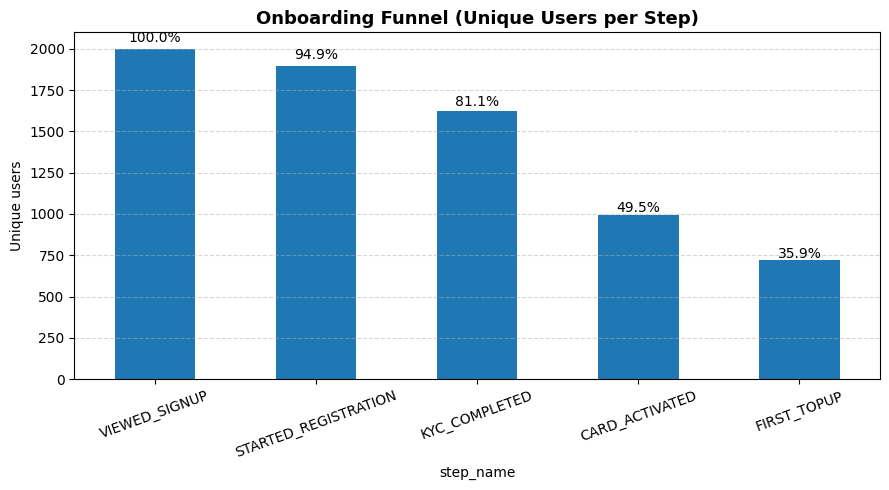

In [6]:
# =====================================================================
# Visual 1: Event-level onboarding funnel (unique users per step)
#
# Tables used:
# - fct_funnel: one row per user per funnel step (event_time + step_name)
#
# Business questions answered:
# - How many unique users reach each key onboarding step?
# - Where is the biggest drop-off in the onboarding journey?
#
# Intuition:
# - Each bar represents how many unique users have at least one event
#   at that specific step_name:
#     VIEWED_SIGNUP → STARTED_REGISTRATION → KYC_COMPLETED → CARD_ACTIVATED → FIRST_TOPUP
# - The percentage label on top of each bar shows the share relative
#   to the very first step (VIEWED_SIGNUP). This is the classical funnel view.
#
# How this could be made more advanced:
# - Build separate funnels per country / device / marketing_channel
#   by filtering fct_funnel or joining with dim_users.
# - Compare funnels over time (e.g. users who signed up this month vs last month).
# - Use this as the base for A/B test comparisons (control vs treatment group).
# =====================================================================

# Convert event_time into datetime format
fct_funnel["event_time"] = pd.to_datetime(fct_funnel["event_time"])

# Define the correct step order to visualize the funnel properly
funnel_order = [
    "VIEWED_SIGNUP",
    "STARTED_REGISTRATION",
    "KYC_COMPLETED",
    "CARD_ACTIVATED",
    "FIRST_TOPUP",
]

# Group by step_name and count unique users (one user counts only once per step)
step_counts = (
    fct_funnel.groupby("step_name")["user_id"]
    .nunique()
    .reindex(funnel_order)   # keeps steps in the correct funnel order
)

# Create the bar chart
plt.figure(figsize=(9, 5))
ax = step_counts.plot(kind="bar")

# Title + axis labels
ax.set_title("Onboarding Funnel (Unique Users per Step)", fontsize=13, fontweight="bold")
ax.set_ylabel("Unique users")
plt.xticks(rotation=20)

# The first step is the baseline for conversion % labels
baseline = step_counts.iloc[0]

# Add percentage labels above each bar
for i, value in enumerate(step_counts):
    if pd.isna(value):
        continue
    percent = (value / baseline) * 100
    ax.text(
        i,
        value * 1.02,
        f"{percent:.1f}%",
        ha="center",
        fontsize=10
    )

# Add horizontal grid lines for readability
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Tight layout for cleaner spacing
plt.tight_layout()

# Save the visual for README
plt.savefig(images_dir / "01_funnel_event_level.png", dpi=200, bbox_inches="tight")

# Show the plot
plt.show()

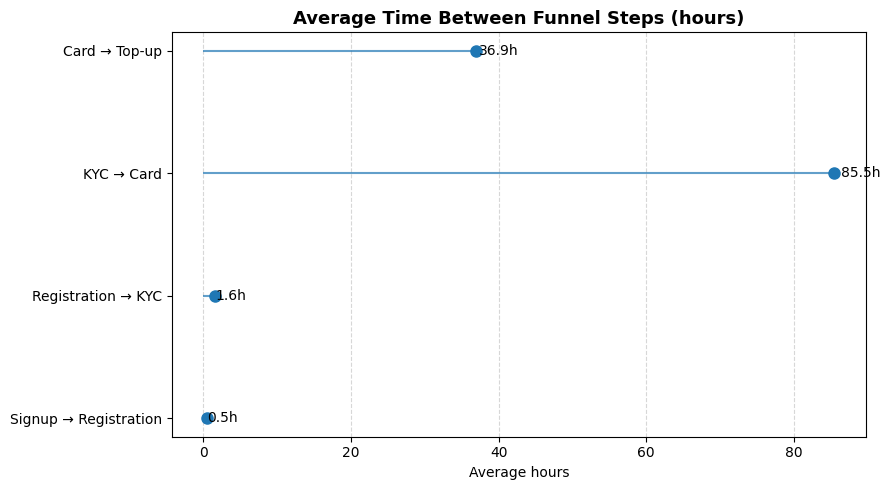

In [2]:
# =====================================================================
# Visual 2 (alternative): Average time between funnel steps (lollipop chart)
#
# Tables used:
# - fct_funnel: event_time per step for each user
#
# Business questions answered:
# - How long do users stay stuck between onboarding steps?
# - Is KYC or card activation the main bottleneck?
#
# Intuition:
# - Same logic as before: compute average hours between each step.
# - Instead of bars, draw a "lollipop" chart (line + marker) for a cleaner look.
#
# How this could be made more advanced:
# - Segment by country / device / cohort.
# - Compare mean vs median duration.
# =====================================================================

# Pivot funnel events into wide format (one row per user, one column per step)
funnel_wide = fct_funnel.pivot_table(
    index="user_id",
    columns="step_name",
    values="event_time",
    aggfunc="first",
)

# Compute time between each pair of steps in hours
funnel_wide["time_signup_to_reg"] = (
    funnel_wide["STARTED_REGISTRATION"] - funnel_wide["VIEWED_SIGNUP"]
).dt.total_seconds() / 3600

funnel_wide["time_reg_to_kyc"] = (
    funnel_wide["KYC_COMPLETED"] - funnel_wide["STARTED_REGISTRATION"]
).dt.total_seconds() / 3600

funnel_wide["time_kyc_to_card"] = (
    funnel_wide["CARD_ACTIVATED"] - funnel_wide["KYC_COMPLETED"]
).dt.total_seconds() / 3600

funnel_wide["time_card_to_topup"] = (
    funnel_wide["FIRST_TOPUP"] - funnel_wide["CARD_ACTIVATED"]
).dt.total_seconds() / 3600

# Take average of each duration column
avg_durations = funnel_wide[
    [
        "time_signup_to_reg",
        "time_reg_to_kyc",
        "time_kyc_to_card",
        "time_card_to_topup",
    ]
].mean().dropna()

# Rename index to nicer labels
avg_durations.index = [
    "Signup → Registration",
    "Registration → KYC",
    "KYC → Card",
    "Card → Top-up",
]

# Prepare x positions for lollipop chart
x_positions = range(len(avg_durations))

plt.figure(figsize=(9, 5))
ax = plt.gca()

# Draw the "sticks" of the lollipops
ax.hlines(
    y=x_positions,
    xmin=0,
    xmax=avg_durations.values,
    linestyle="-",
    alpha=0.7,
)

# Draw the "heads" of the lollipops
ax.plot(
    avg_durations.values,
    x_positions,
    "o",
    markersize=8,
)

# Titles and labels
ax.set_title("Average Time Between Funnel Steps (hours)", fontsize=13, fontweight="bold")
ax.set_xlabel("Average hours")
ax.set_yticks(x_positions)
ax.set_yticklabels(avg_durations.index)

# Add labels at the end of each lollipop
for value, y in zip(avg_durations.values, x_positions):
    ax.text(
        value * 1.01,
        y,
        f"{value:.1f}h",
        va="center",
        fontsize=10,
    )

# Add vertical grid lines
ax.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(images_dir / "02_funnel_step_durations_lollipop.png", dpi=200, bbox_inches="tight")
plt.show()


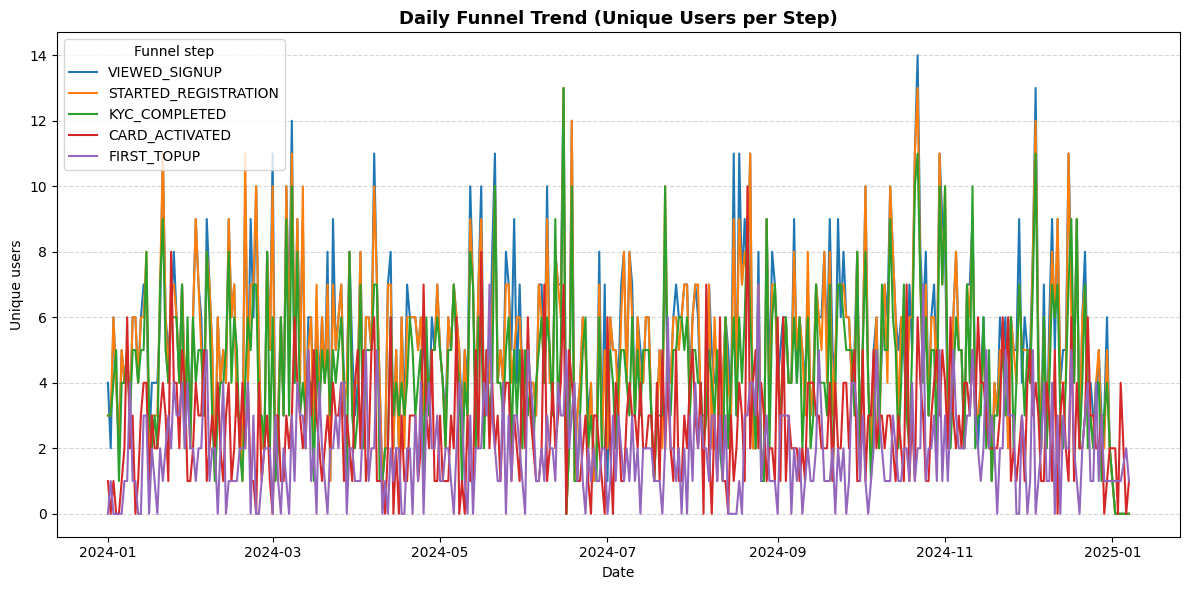

In [8]:
# =====================================================================
# Visual 3: Daily funnel trend (unique users per step per day)
#
# Tables used:
# - fct_funnel: per-user funnel events over time
#
# Business questions answered:
# - Are funnel steps stable or changing over time?
# - Do product launches or issues show up as spikes or drops in certain steps?
#
# Intuition:
# - For each day and each step_name, count unique users.
# - Each line in the plot corresponds to one funnel step over time.
#
# How this could be made more advanced:
# - Add rolling averages (e.g. 7-day moving average) to smooth noise.
# - Compare different time periods (before vs after a feature launch).
# - Filter to specific segments (country, device, marketing channel).
# =====================================================================

# Extract date from event_time (drop the time of day)
fct_funnel["event_date"] = fct_funnel["event_time"].dt.date

# Group by date and step_name, count unique users, and unstack to columns
daily_funnel = (
    fct_funnel.groupby(["event_date", "step_name"])["user_id"]
    .nunique()
    .unstack(fill_value=0)
    .reindex(columns=funnel_order, fill_value=0)  # keep funnel order of steps
)

# Create line chart with one line per funnel step
plt.figure(figsize=(12, 6))
ax = plt.gca()

for col in daily_funnel.columns:
    ax.plot(daily_funnel.index, daily_funnel[col], linewidth=1.5, label=col)

# Titles and labels
ax.set_title("Daily Funnel Trend (Unique Users per Step)", fontsize=13, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Unique users")
ax.legend(title="Funnel step")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "03_funnel_daily_trend.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


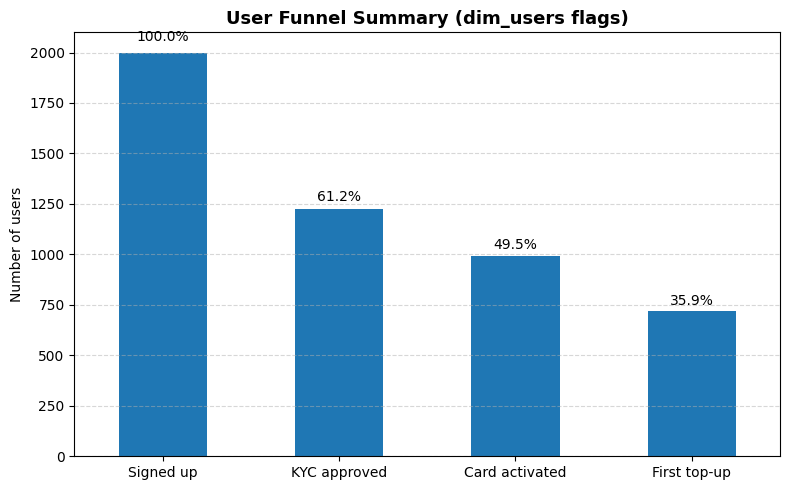

In [2]:
# =====================================================================
# Visual 4: High-level funnel summary using dim_users flags
#
# Tables used:
# - dim_users: one row per user with boolean flags like:
#   has_kyc_approved, has_card_activated, has_topup
#
# Business questions answered:
# - Overall, how many users:
#   • pass KYC
#   • activate a card
#   • perform at least one top-up
#
# Intuition:
# - This is a user-level funnel based on final states, not individual events.
# - It complements the event-level funnel from fct_funnel.
#
# How this could be made more advanced:
# - Compute funnels per country, device, or marketing channel.
# - Add revenue metrics for each funnel stage.
# =====================================================================

# Compute counts for each stage using boolean flags
total_signups = len(dim_users)
kyc_approved = dim_users["has_kyc_approved"].sum()
card_activated = dim_users["has_card_activated"].sum()
topup_users = dim_users["has_topup"].sum()

# Build a small Series with funnel counts
user_funnel_counts = pd.Series(
    {
        "Signed up": total_signups,
        "KYC approved": kyc_approved,
        "Card activated": card_activated,
        "First top-up": topup_users,
    }
)

# Create bar chart
plt.figure(figsize=(8, 5))
ax = user_funnel_counts.plot(kind="bar")

# Titles and labels
ax.set_title("User Funnel Summary (dim_users flags)", fontsize=13, fontweight="bold")
ax.set_ylabel("Number of users")
ax.set_xlabel("")
plt.xticks(rotation=0)

# Use the first bar as baseline for % labels
baseline = user_funnel_counts.iloc[0]

# Add percentage labels above bars (share of signed-up users)
for i, v in enumerate(user_funnel_counts):
    pct = v / baseline * 100
    ax.text(
        i,
        v * 1.02,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Add horizontal grid lines
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "04_funnel_dim_users.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


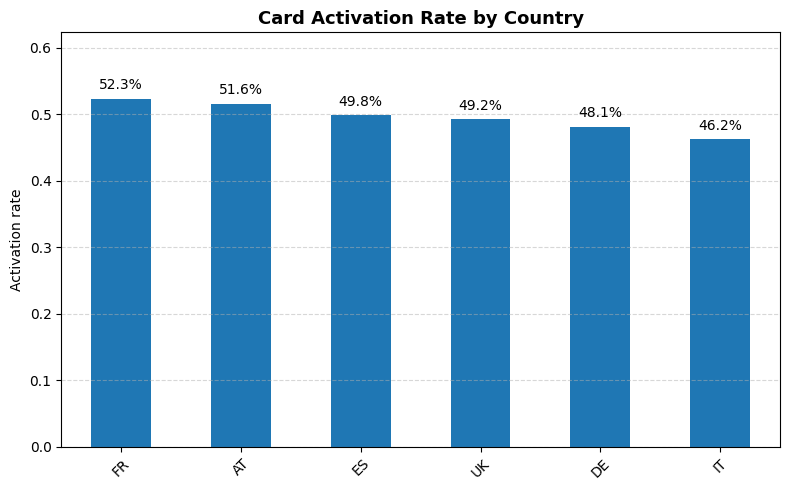

In [3]:
# =====================================================================
# Visual 5: Card activation rate by country
#
# Tables used:
# - dim_users: country + has_card_activated
#
# Business questions answered:
# - In which countries does onboarding (up to card activation) perform best?
# - Are there markets where users drop off after KYC instead of activating?
#
# Intuition:
# - For each country, compute:
#   users  = number of users in that country
#   activated = users with has_card_activated = True
#   activation_rate = activated / users
#
# How this could be made more advanced:
# - Filter to recent cohorts only (e.g. last 30 days).
# - Combine with revenue metrics (which countries are most valuable).
# - Add error bars / confidence intervals for small countries.
# =====================================================================

# Group by country and aggregate total users + activated users
country_stats = dim_users.groupby("country").agg(
    users=("user_id", "count"),
    activated=("has_card_activated", "sum"),
)

# Compute activation_rate = activated / users
country_stats["activation_rate"] = country_stats["activated"] / country_stats["users"]

# Sort countries by activation_rate (highest first)
country_stats = country_stats.sort_values("activation_rate", ascending=False)

# Create bar chart of activation_rate
plt.figure(figsize=(8, 5))
ax = country_stats["activation_rate"].plot(kind="bar")

# Titles and labels
ax.set_title("Card Activation Rate by Country", fontsize=13, fontweight="bold")
ax.set_ylabel("Activation rate")
ax.set_xlabel("")
plt.xticks(rotation=45)

# Add % labels on top of each bar
for i, v in enumerate(country_stats["activation_rate"]):
    ax.text(
        i,
        v + 0.01,
        f"{v * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Set y-axis limit slightly above max for space for labels
ax.set_ylim(0, min(1.15, country_stats["activation_rate"].max() + 0.1))

# Add grid lines on y-axis
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "05_activation_rate_country.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


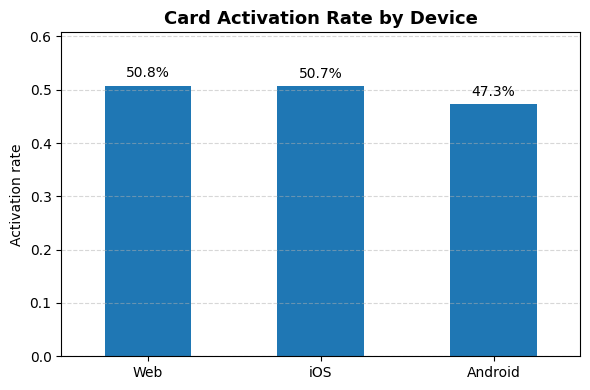

In [2]:
# =====================================================================
# Visual 6: Card activation rate by device
#
# Tables used:
# - dim_users: device + has_card_activated
#
# Business questions answered:
# - Does onboarding work better on iOS, Android, or Web?
# - Which platform should product/design focus on to improve activation?
#
# Intuition:
# - Same logic as Visual 5, but grouped by device instead of country.
#
# How this could be made more advanced:
# - Split by app version (if available).
# - Combine with funnel step data to see where each device struggles.
# =====================================================================

# Group by device and aggregate total users + activated users
device_stats = dim_users.groupby("device").agg(
    users=("user_id", "count"),
    activated=("has_card_activated", "sum"),
)

# Compute activation_rate = activated / users
device_stats["activation_rate"] = device_stats["activated"] / device_stats["users"]

# Sort by activation_rate
device_stats = device_stats.sort_values("activation_rate", ascending=False)

# Create bar chart
plt.figure(figsize=(6, 4))
ax = device_stats["activation_rate"].plot(kind="bar")

# Titles and labels
ax.set_title("Card Activation Rate by Device", fontsize=13, fontweight="bold")
ax.set_ylabel("Activation rate")
ax.set_xlabel("")
plt.xticks(rotation=0)

# Add % labels on top of each bar
for i, v in enumerate(device_stats["activation_rate"]):
    ax.text(
        i,
        v + 0.01,
        f"{v * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Set y-limit a bit higher to leave space for labels
ax.set_ylim(0, min(1.15, device_stats["activation_rate"].max() + 0.1))

# Add y-axis grid lines
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "06_activation_rate_device.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


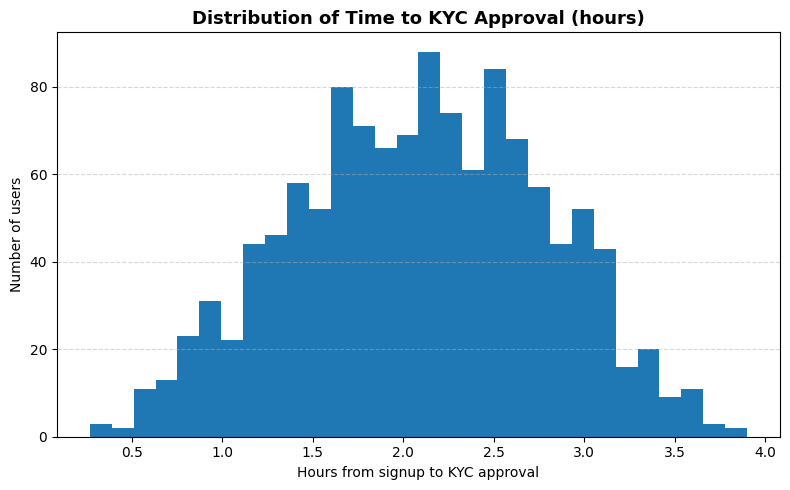

In [2]:
# =====================================================================
# Visual 7: Distribution of time to KYC approval (hours)
#
# Tables used:
# - dim_users: time_to_kyc_hours + has_kyc_approved
#
# Business questions answered:
# - How long does KYC typically take for approved users?
# - Is the KYC process fast enough, or are there long tails?
#
# Intuition:
# - Take only users who have has_kyc_approved = True.
# - Then plot a histogram of time_to_kyc_hours.
# - The shape of the distribution shows how fast/slow KYC is.
#
# How this could be made more advanced:
# - Compare distributions per country or device.
# - Use percentiles (e.g. 80% of users approved within X hours).
# - Track this distribution over time by signup cohort.
# =====================================================================

# Filter to users with KYC approved
approved_users = dim_users[dim_users["has_kyc_approved"] == True]

# Extract the KYC duration column and drop missing values
kyc_durations = approved_users["time_to_kyc_hours"].dropna()

# Create histogram
plt.figure(figsize=(8, 5))
ax = kyc_durations.plot(kind="hist", bins=30)

# Titles and axis labels
ax.set_title("Distribution of Time to KYC Approval (hours)", fontsize=13, fontweight="bold")
ax.set_xlabel("Hours from signup to KYC approval")
ax.set_ylabel("Number of users")

# Add horizontal grid lines
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "07_kyc_duration_distribution.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


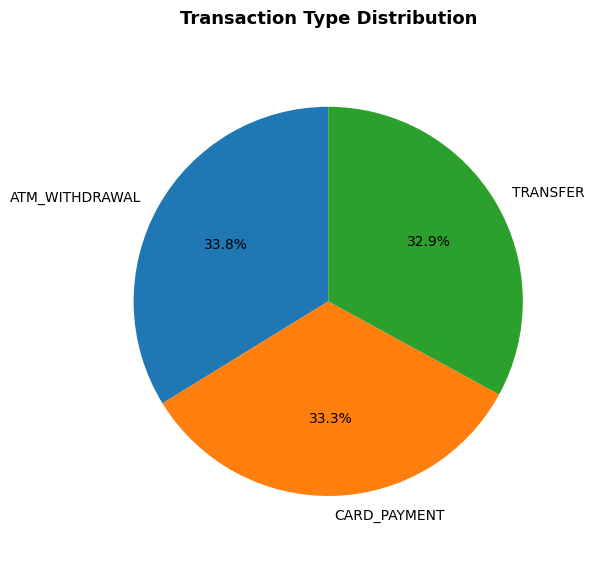

In [3]:
# =====================================================================
# Visual 8: Transaction type distribution (pie chart)
#
# Tables used:
# - fct_transactions: transaction_type
#
# Business questions answered:
# - How do users mainly use the product?
#   • card payments?
#   • ATM withdrawals?
#   • transfers?
#
# Intuition:
# - Count how many transactions of each type exist.
# - Then show their share in a pie chart.
#
# How this could be made more advanced:
# - Weight by amount_eur instead of simple counts.
# - Compare distribution per country or device.
# - Compare “new users” cohort vs “mature users”.
# =====================================================================

# Count transactions per transaction_type
txn_type_counts = fct_transactions["transaction_type"].value_counts()

# Create pie chart
plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.pie(
    txn_type_counts.values,
    labels=txn_type_counts.index,
    autopct="%1.1f%%",      # show percentages
    startangle=90,          # start from top
)

# Title
ax.set_title("Transaction Type Distribution", fontsize=13, fontweight="bold")

# Make sure pie is drawn as a circle
ax.axis("equal")

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "08_transaction_type_pie.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


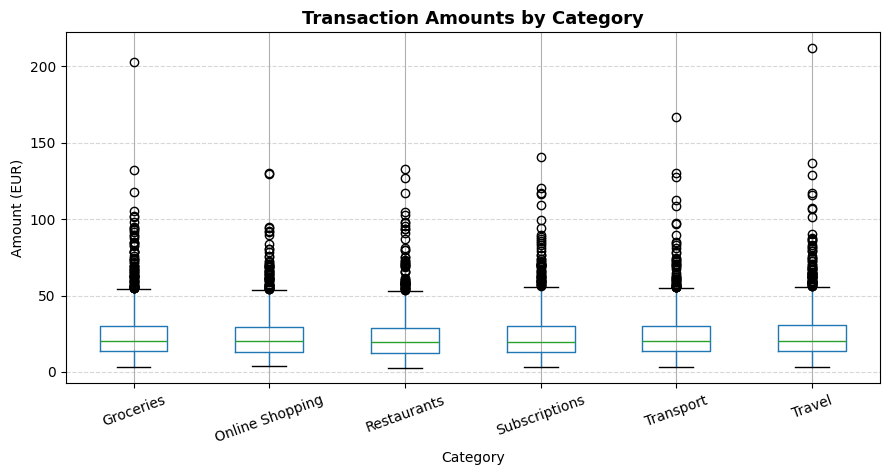

In [4]:
# =====================================================================
# Visual 9: Transaction amounts by category (boxplot)
#
# Tables used:
# - fct_transactions: category + amount_eur
#
# Business questions answered:
# - How do transaction amounts differ across categories?
# - Are some categories more "high-ticket" than others?
#
# Intuition:
# - A boxplot shows median, quartiles, and outliers per category.
# - This is richer than just average amount per category.
#
# How this could be made more advanced:
# - Limit to specific segments (e.g. only card payments).
# - Compare distributions across countries.
# - Log-transform amounts to reduce the impact of outliers.
# =====================================================================

# Choose top N categories by transaction count for a readable plot
top_n = 6
top_categories = (
    fct_transactions["category"]
    .value_counts()
    .head(top_n)
    .index
)

# Filter transactions to only the top categories
txn_top = fct_transactions[fct_transactions["category"].isin(top_categories)]

# Create boxplot of amount_eur grouped by category
plt.figure(figsize=(9, 5))
ax = plt.gca()
txn_top.boxplot(
    column="amount_eur",
    by="category",
    ax=ax
)

# Titles and labels
ax.set_title("Transaction Amounts by Category", fontsize=13, fontweight="bold")
plt.suptitle("")  # remove automatic pandas "Boxplot grouped by" title
ax.set_xlabel("Category")
ax.set_ylabel("Amount (EUR)")
plt.xticks(rotation=20)

# Add grid for readability
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "09_amount_boxplot_by_category.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()


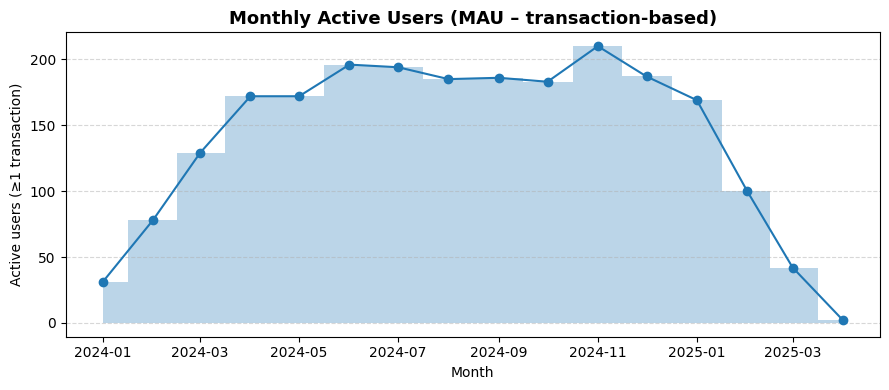

In [5]:
# =====================================================================
# Visual 10: Monthly Active Users (MAU – transaction-based, area chart)
#
# Tables used:
# - fct_transactions: transaction_date + user_id
#
# Business questions answered:
# - How many users are active (at least one transaction) per month?
# - Is product engagement growing, stable, or declining?
#
# Intuition:
# - For each month, count distinct user_id values with ≥1 transaction.
# - Then plot this as an area chart to emphasize the "volume" of active users.
#
# How this could be made more advanced:
# - Compute separate MAU definitions (e.g. app opens, card-present only).
# - Add ARPU (Average Revenue Per User) on top.
# - Compare MAU per segment (country / device / signup cohort).
# =====================================================================

# Ensure transaction_date is datetime
fct_transactions["transaction_date"] = pd.to_datetime(fct_transactions["transaction_date"])

# Create a period column for year-month (e.g. 2024-01)
fct_transactions["transaction_month"] = fct_transactions["transaction_date"].dt.to_period("M")

# Group by month and count unique users
mau = (
    fct_transactions.groupby("transaction_month")["user_id"]
    .nunique()
    .reset_index()
)

# Convert period back to timestamp for plotting
mau["transaction_month"] = mau["transaction_month"].dt.to_timestamp()

# Create area chart
plt.figure(figsize=(9, 4))
ax = plt.gca()

# Fill area under the line
ax.fill_between(
    mau["transaction_month"],
    mau["user_id"],
    step="mid",
    alpha=0.3
)

# Draw the line on top
ax.plot(
    mau["transaction_month"],
    mau["user_id"],
    marker="o",
    linewidth=1.5
)

# Titles and labels
ax.set_title("Monthly Active Users (MAU – transaction-based)", fontsize=13, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Active users (≥1 transaction)")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Clean layout
plt.tight_layout()

# Save visual for README
plt.savefig(images_dir / "10_mau_area.png", dpi=200, bbox_inches="tight")

# Show plot
plt.show()
